In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import requests
from bs4 import BeautifulSoup
from io import StringIO

from data.omni import OMNI
from data.wsa_enlil import WSA_ENLIL
from data.eswf3_2 import ESWF3_2
from data.dl_model import DL_Model

CR_df = (
    pd.read_csv('E:/research/SW_Speed_Models_Comparison/data/Carrington_Rotation_Data__Oct-Dec__2010-2020_.csv')
      .assign(
          Start=lambda df: pd.to_datetime(df['Start Date']),
          End  =lambda df: pd.to_datetime(df['End Date'])
      )
)

In [2]:
def CR_listing(cr):
    CR_df['Start Date'] = pd.to_datetime(CR_df['Start Date'])
    CR_df['End Date']   = pd.to_datetime(CR_df['End Date'])
    
    row = CR_df.loc[CR_df['Carrington Rotation Number'] == cr].iloc[0]
    
    times = pd.date_range(row['Start Date'], row['End Date'], freq='1h')
    selected = times[times.hour % 6 == 0]
    
    return selected.strftime('%Y-%m-%d %H:00').tolist()

## ICME events

In [3]:
# ICME event list URL
ICME_url = "https://izw1.caltech.edu/ACE/ASC/DATA/level3/icmetable2.htm"
response = requests.get(ICME_url)

if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table')
    icme = pd.read_html(StringIO(str(table)))[0]



    # select the columns (ICME_start, ICME_end, ICME_mean, ICME_max)
    icme = icme.iloc[:, [1, 2, 11, 12]]
    icme.columns = ["ICME_start", "ICME_end", "ICME_mean", "ICME_max"]
    icme = icme.dropna(subset=["ICME_start", "ICME_end"])

    for col in ["ICME_start", "ICME_end"]:
        icme[col] = pd.to_datetime(icme[col],
                                   format="%Y/%m/%d %H%M",
                                   errors="coerce")

    t0 = pd.Timestamp("2012-10-01")
    t1 = pd.Timestamp("2020-12-31 23:59")
    mask = (
        icme['ICME_start'].dt.year.between(2012, 2020) &
        icme['ICME_start'].dt.month.isin([10, 11, 12]) &
        icme['ICME_end']  .dt.year.between(2012, 2020) &
        icme['ICME_end']  .dt.month.isin([10, 11, 12])
    )
    icme = icme.loc[mask].reset_index(drop=True)


    # 6) [(start_str, end_str), …] 형태의 리스트로
    icme_event_list = icme[["ICME_start", "ICME_end"]].apply(
        lambda r: [r["ICME_start"].strftime("%Y-%m-%d %H:%M"),
                   r["ICME_end"].strftime("%Y-%m-%d %H:%M")],
        axis=1
    ).tolist()

else:
    print(f"Request failed with status code: {response.status_code}")

print("Number of ICME events:", len(icme_event_list))
icme_event_list

Number of ICME events: 32


[['2012-10-01 00:00', '2012-10-02 00:00'],
 ['2012-10-02 22:00', '2012-10-03 06:00'],
 ['2012-10-08 18:00', '2012-10-09 12:00'],
 ['2012-10-12 22:00', '2012-10-13 10:00'],
 ['2012-11-01 00:00', '2012-11-02 03:00'],
 ['2012-11-09 03:00', '2012-11-09 15:00'],
 ['2012-11-13 08:00', '2012-11-14 03:00'],
 ['2012-11-24 12:00', '2012-11-25 10:00'],
 ['2012-11-26 12:00', '2012-11-28 05:00'],
 ['2012-11-28 18:00', '2012-11-29 14:00'],
 ['2012-12-14 07:00', '2012-12-14 17:00'],
 ['2013-10-02 23:00', '2013-10-03 22:00'],
 ['2013-10-09 09:00', '2013-10-11 00:00'],
 ['2013-11-08 22:00', '2013-11-09 07:00'],
 ['2013-11-11 17:00', '2013-11-12 03:00'],
 ['2013-12-01 11:00', '2013-12-02 23:00'],
 ['2013-12-15 16:00', '2013-12-16 05:00'],
 ['2013-12-25 05:00', '2013-12-25 17:00'],
 ['2014-11-11 07:00', '2014-11-11 20:00'],
 ['2014-12-22 04:00', '2014-12-22 17:00'],
 ['2015-10-25 14:00', '2015-10-27 04:00'],
 ['2015-11-04 15:00', '2015-11-04 19:00'],
 ['2015-11-07 06:00', '2015-11-08 16:00'],
 ['2015-12-

---

In [4]:
def POD(TP, FP, FN):
    return TP / (TP + FN)

def FNR(TP, FP, FN):
    return FN / (TP + FN)

def PPV(TP, FP, FN):
    return TP / (TP + FP)

def FAR(TP, FP, FN):
    return FP / (TP + FP)

def TS(TP, FP, FN):
    return TP / (TP + FP + FN)

def BS(TP, FP, FN):
    return (TP + FP) / (TP + FN)

def event_verification(TP, FP, FN):
    return np.round(POD(TP, FP, FN), 2), np.round(FNR(TP, FP, FN), 2), \
            np.round(PPV(TP, FP, FN), 2), np.round(FAR(TP, FP, FN), 2), \
            np.round(TS(TP, FP, FN), 2), np.round(BS(TP, FP, FN), 2)

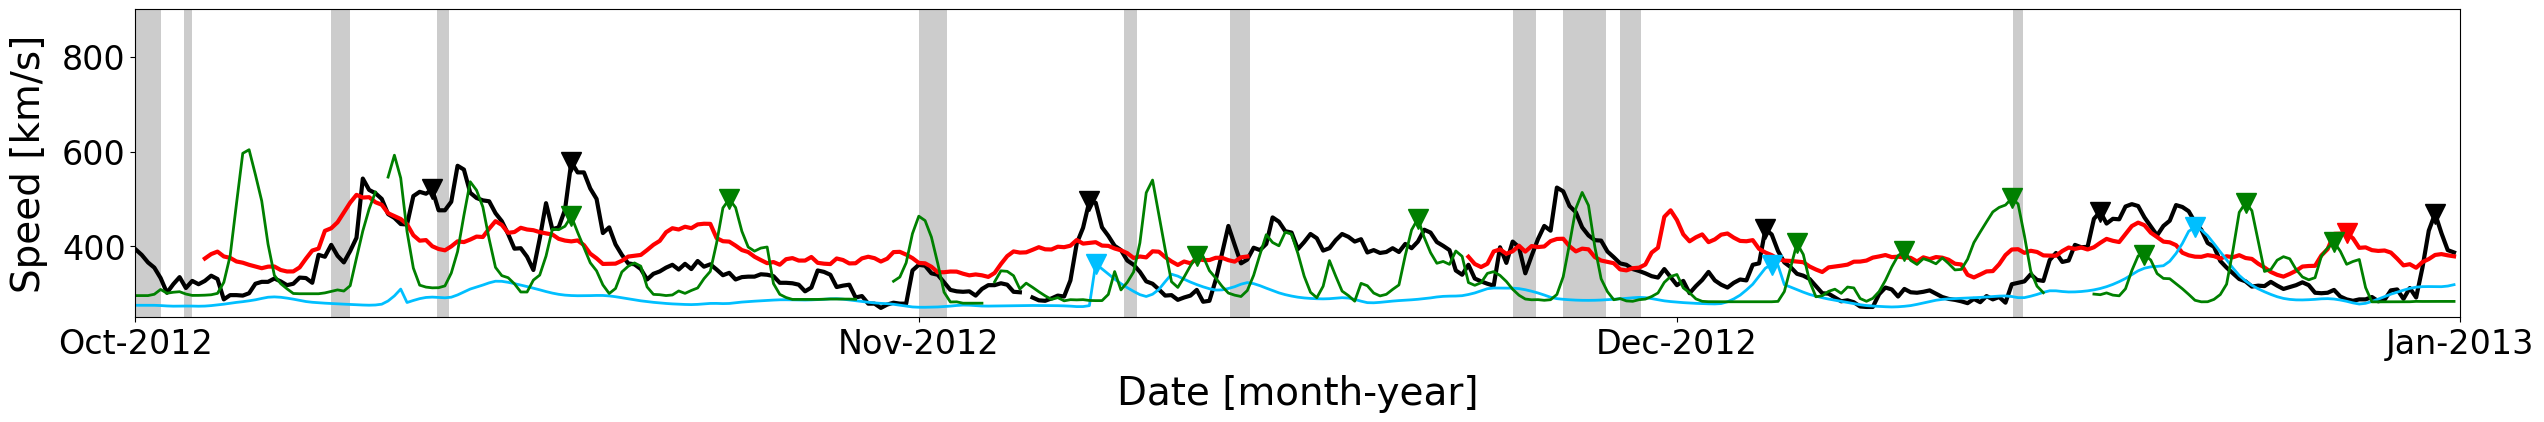

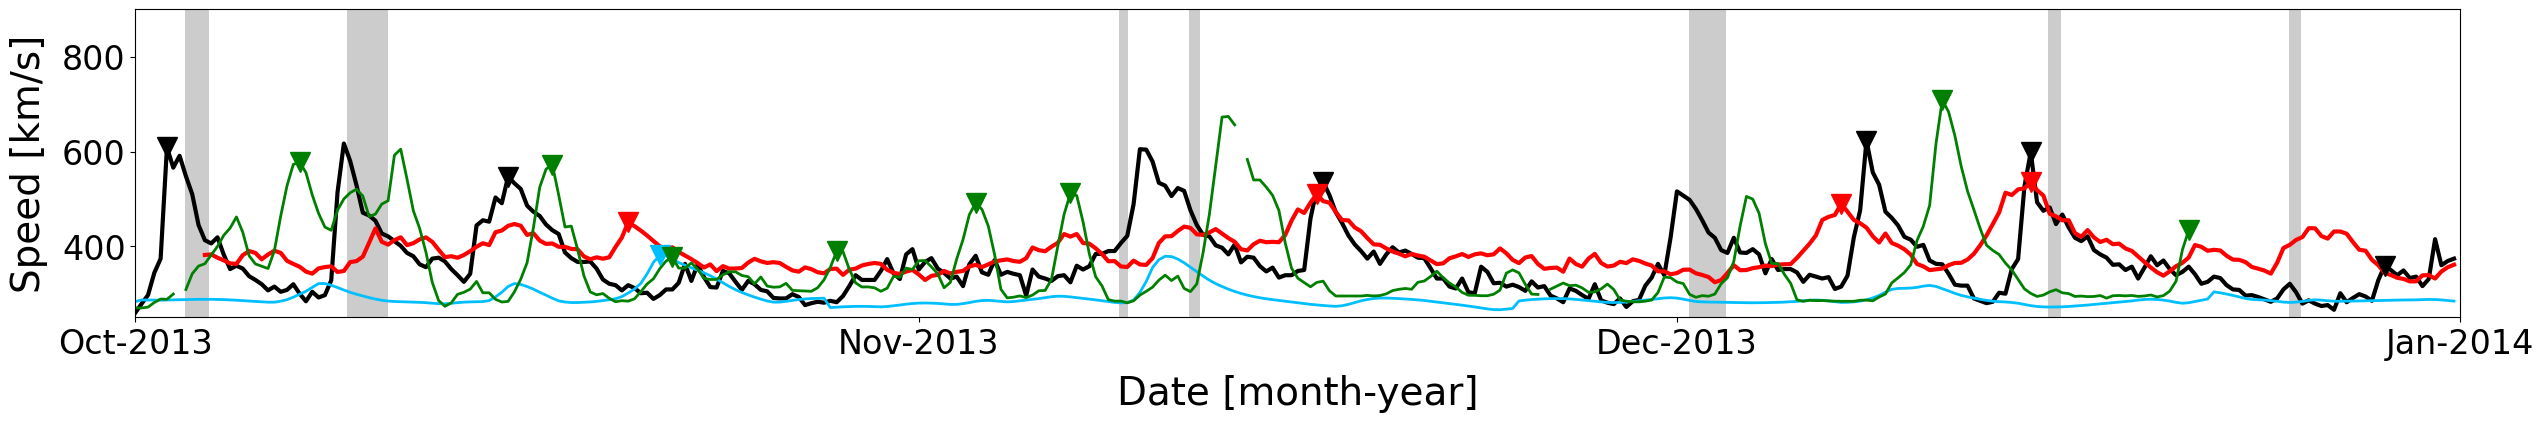

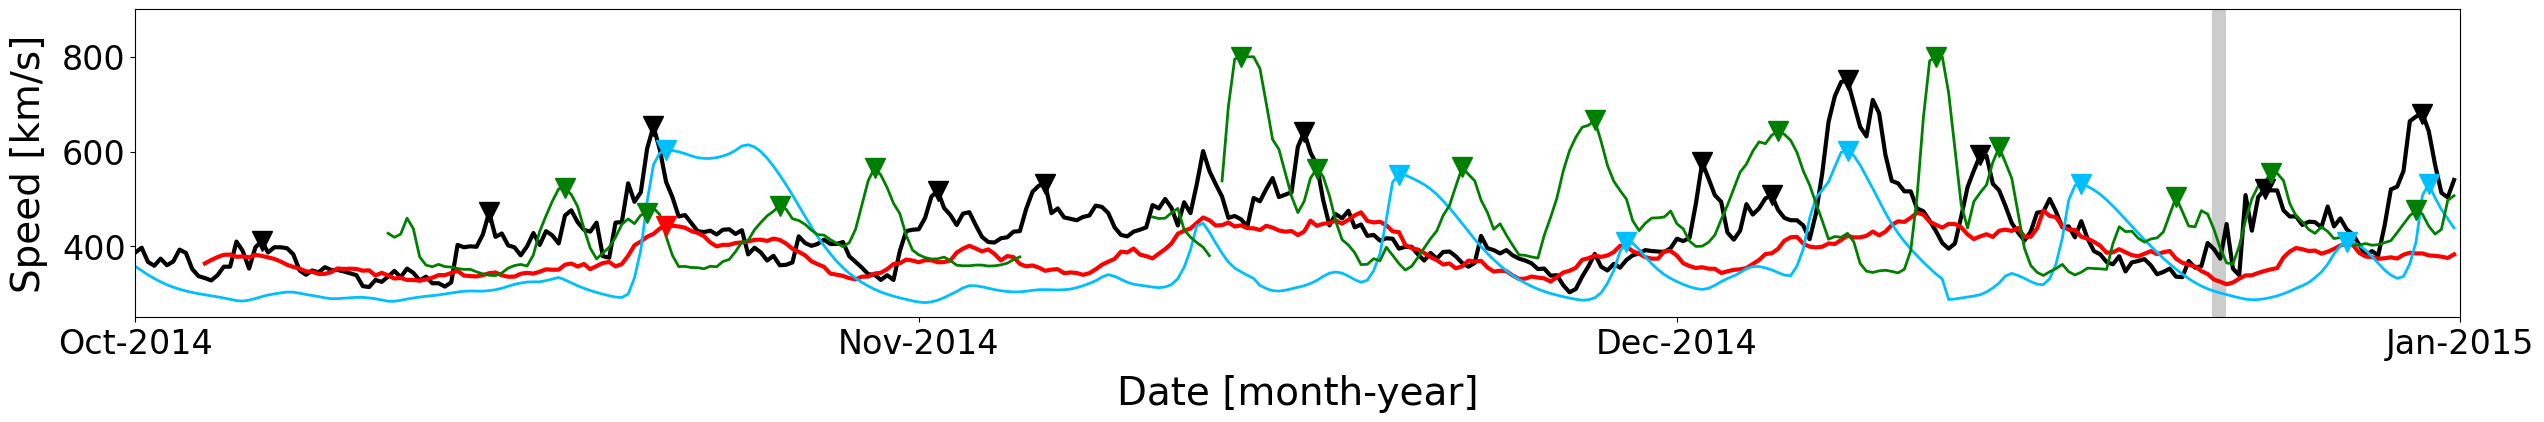

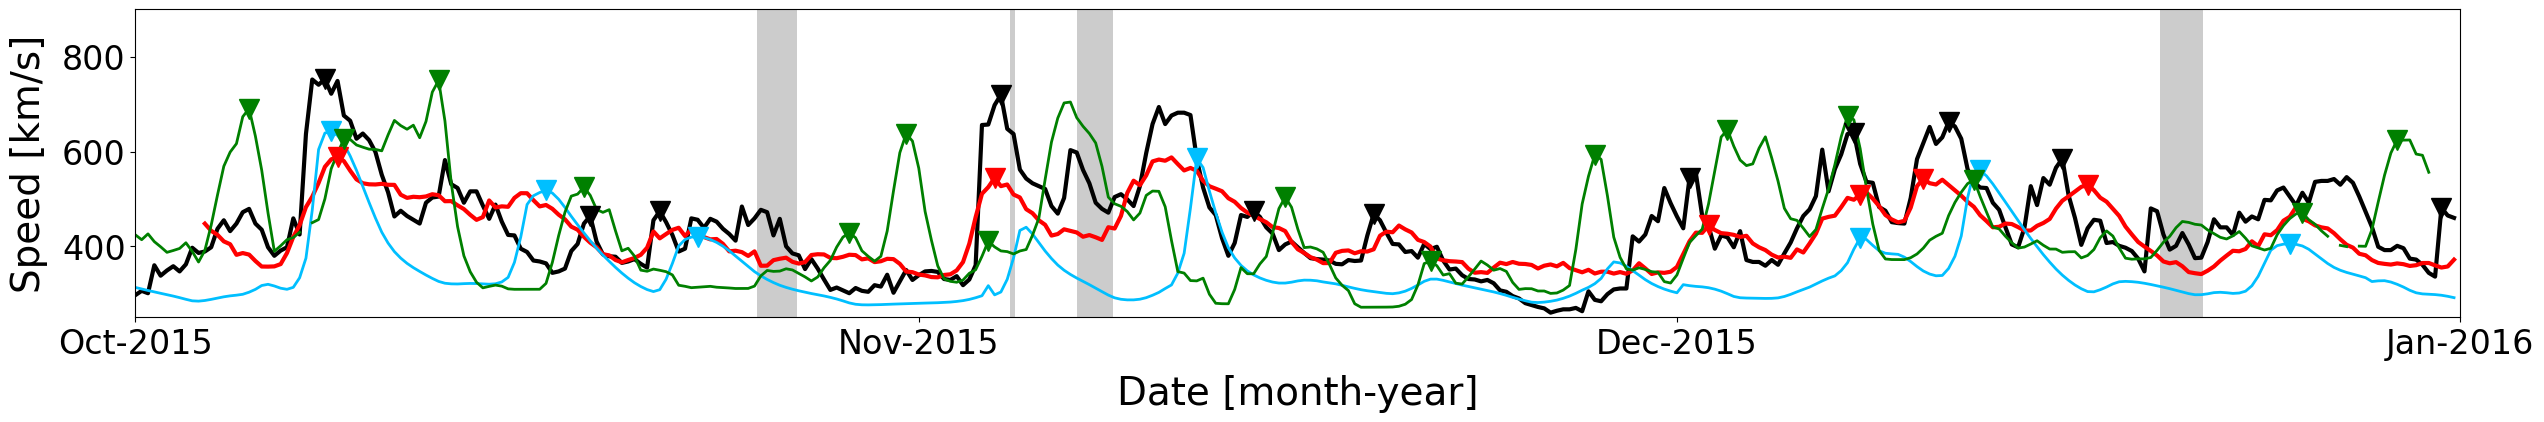

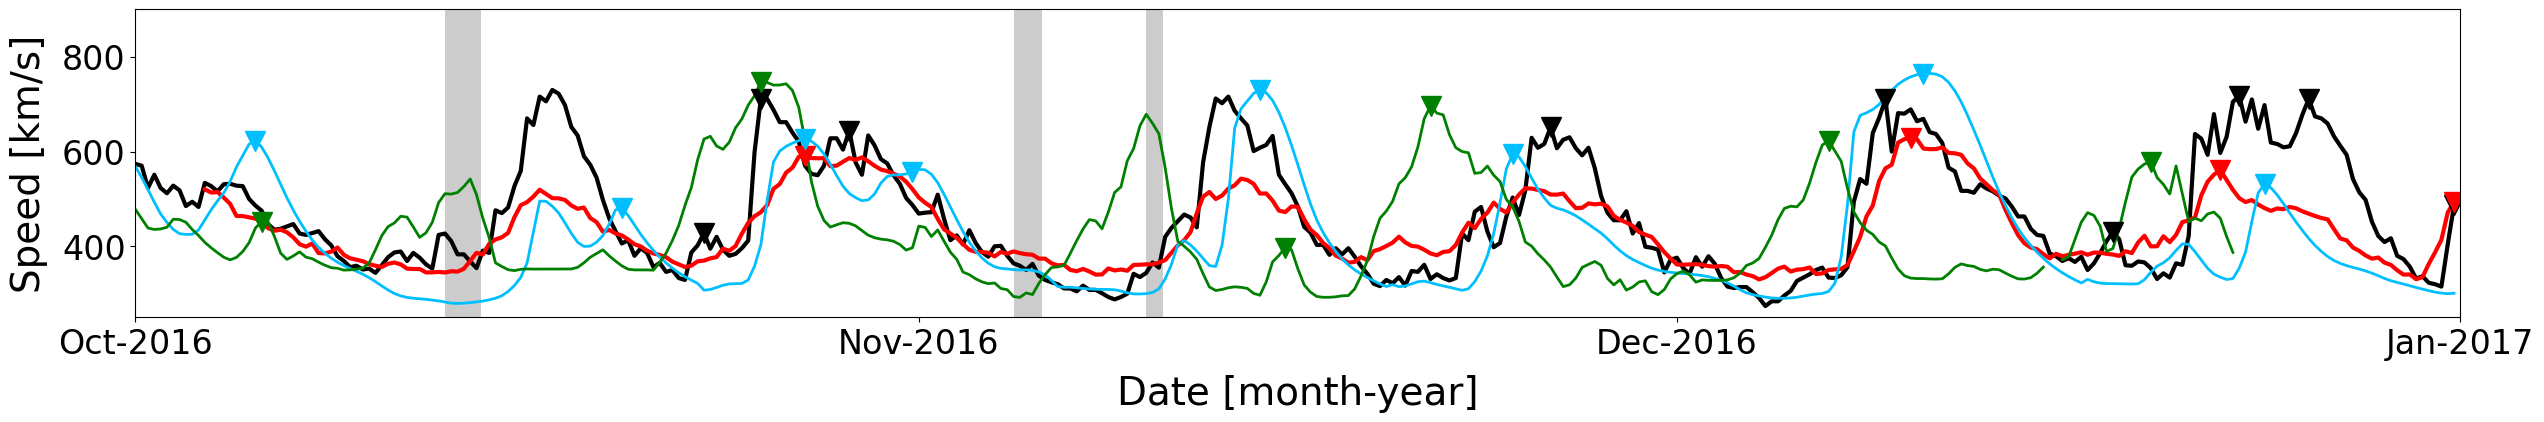

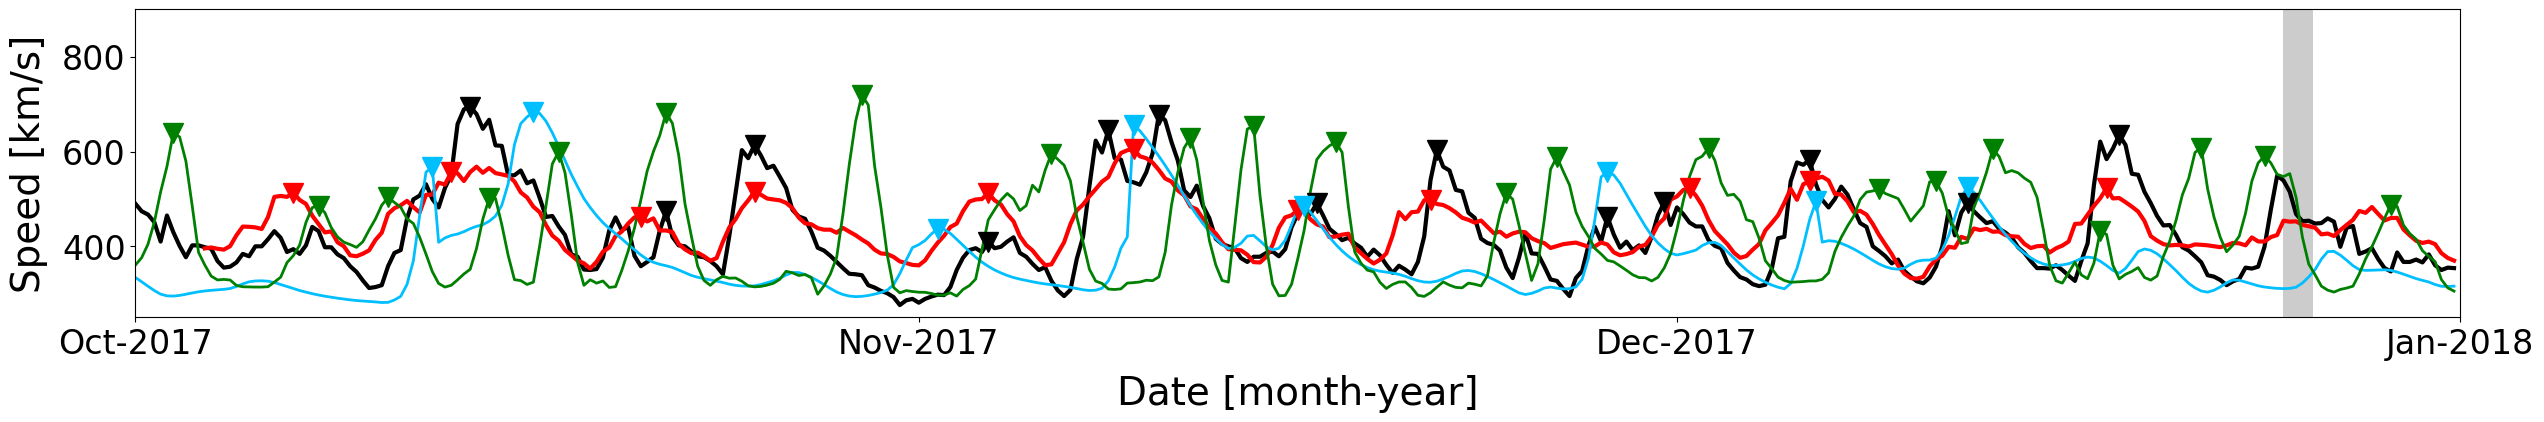

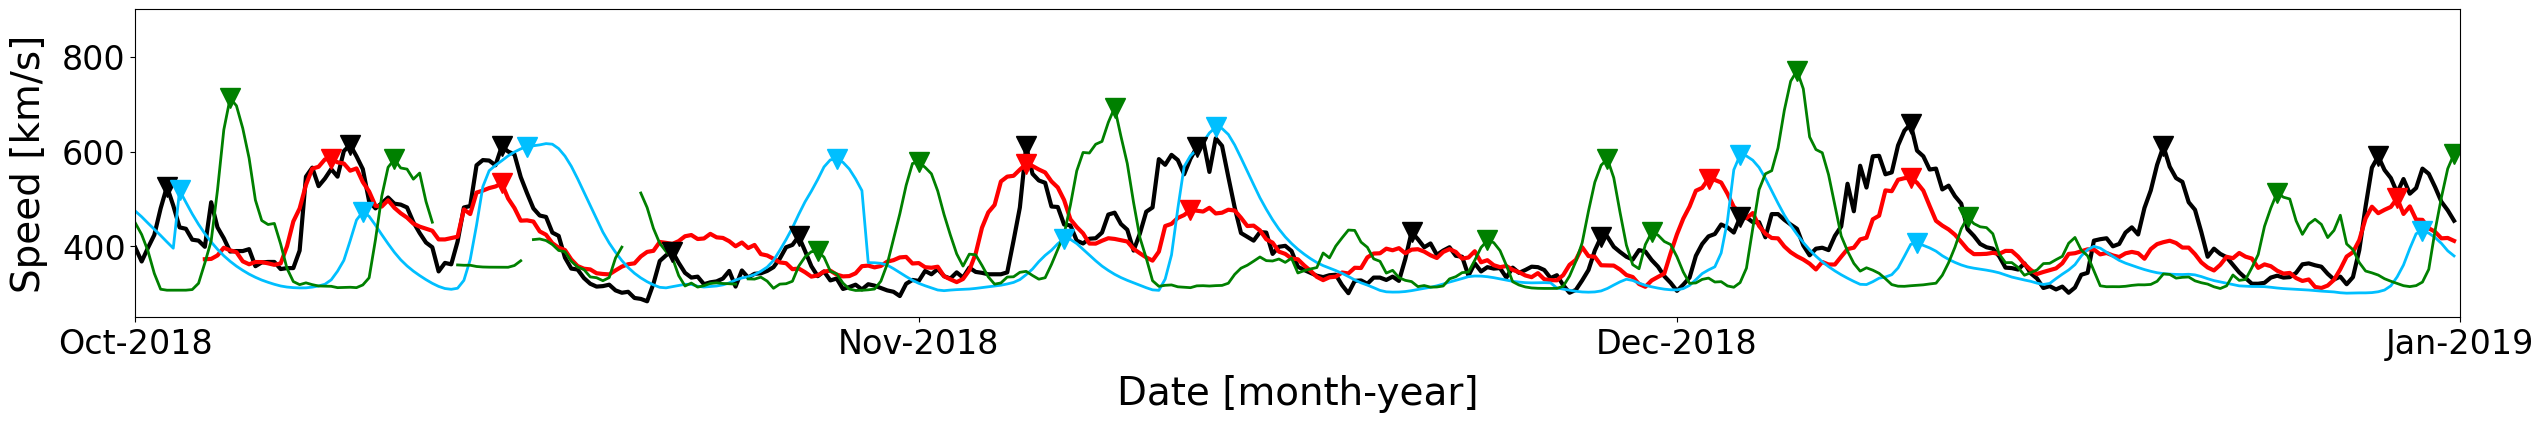

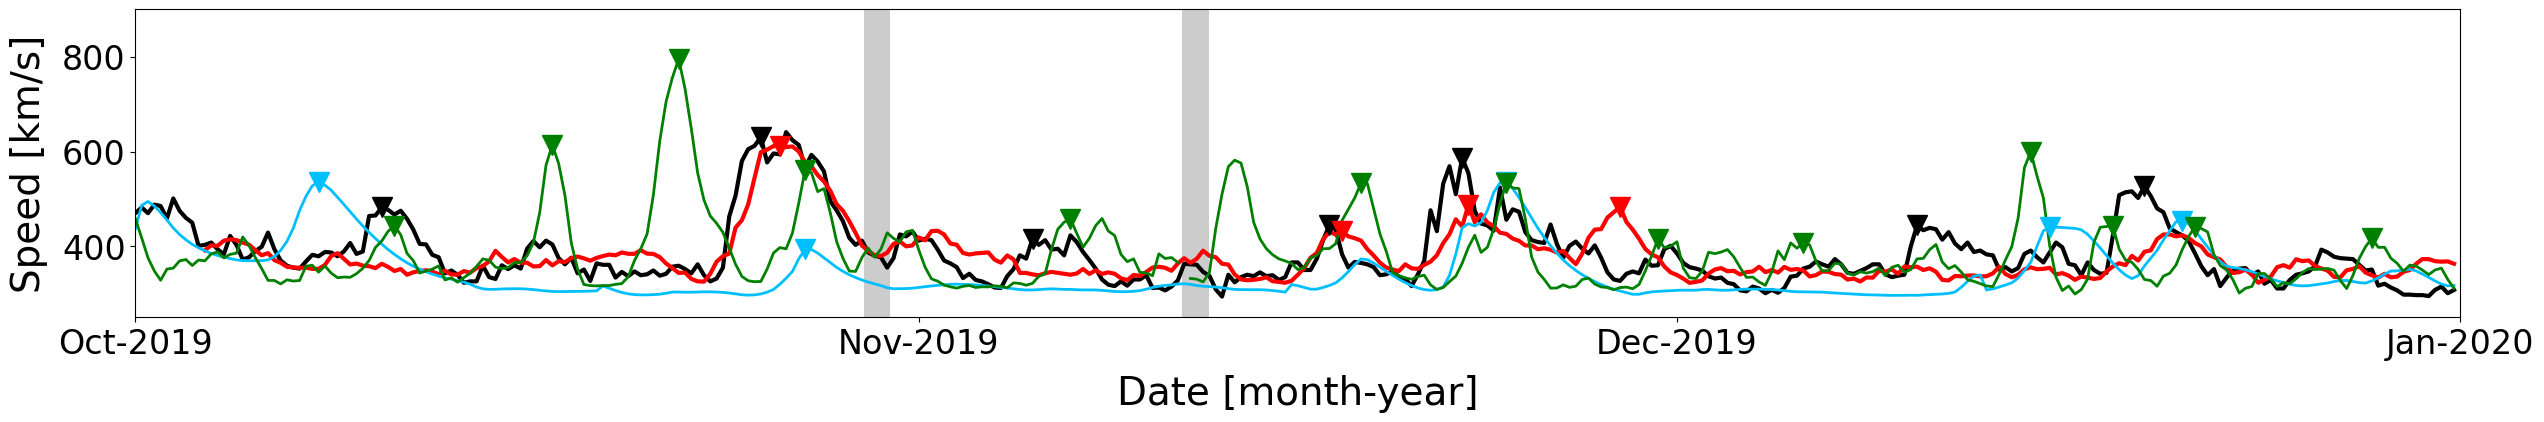

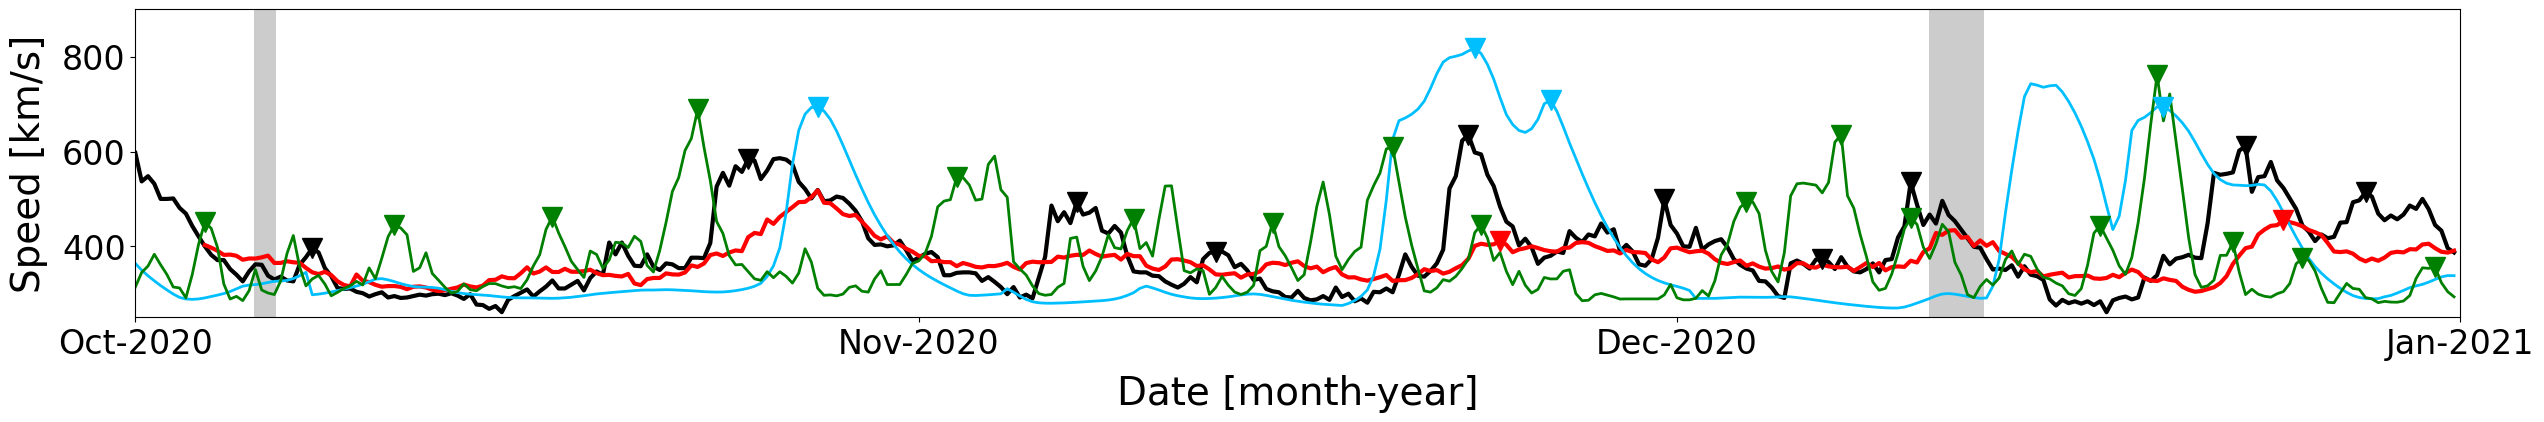

In [5]:
sorted_by_years = {
    '2012': [2128, 2129, 2130, 2131, 2132], 
    '2013': [2141, 2142, 2143, 2144, 2145], 
    '2014': [2155, 2156, 2157, 2158], 
    '2015': [2168, 2169, 2170, 2171, 2172], 
    '2016': [2182, 2183, 2184, 2185], 
    '2017': [2195, 2196, 2197, 2198, 2199], 
    '2018': [2208, 2209, 2210, 2211, 2212], 
    '2019': [2222, 2223, 2224, 2225], 
    '2020': [2235, 2236, 2237, 2238, 2239]
}

omni_peaks_list = []
model_peaks_list = []
wsa_peaks_list = []
eswf_peaks_list = []

for year in sorted_by_years:

    CR_list = sorted_by_years[year]
    time_list = []
    
    omni_dates_list, omni_speeds_list = [], []
    model_dates_list, model_speeds_list = [], []
    wsa_dates_list, wsa_speeds_list = [], []
    eswf3_2dates_list, eswf3_2speeds_list = [], []
    
    icme_events = []
    for CR in CR_list:
        time_crlist = [time for time in (datetime.strptime(time_str, '%Y-%m-%d %H:%M') for time_str in CR_listing(CR)) if time.month <= 12]
        time_list.extend(time_crlist)
        
        rotation_period = CR_df[CR_df['Carrington Rotation Number'] == CR]
        start_date = pd.to_datetime(rotation_period.iloc[0]['Start Date'])
        end_date = pd.to_datetime(rotation_period.iloc[0]['End Date'])
        
        for icme in icme_event_list:
            icme_start, icme_end = icme
            icme_start = datetime.strptime(icme_start, '%Y-%m-%d %H:%M')
            icme_end = datetime.strptime(icme_end, '%Y-%m-%d %H:%M')
            
            if start_date <= icme_start <= end_date and start_date <= icme_end <= end_date:
                icme_events.append([icme_start, icme_end])
        
        # Model data
        omni_dates, omni_speeds = OMNI(CR)
        model_dates, model_speeds = DL_Model(CR)
        wsa_dates, wsa_speeds = WSA_ENLIL(CR)
        eswf3_2dates, eswf3_2speeds = ESWF3_2(CR)
    
        omni_dates_list.extend(omni_dates)
        omni_speeds_list.extend(omni_speeds)
            
        model_dates_list.extend(model_dates)
        model_speeds_list.extend(model_speeds)
    
        wsa_dates_list.extend(wsa_dates)
        wsa_speeds_list.extend(wsa_speeds)
    
        eswf3_2dates_list.extend(eswf3_2dates)
        eswf3_2speeds_list.extend(eswf3_2speeds)
    
    plt.figure(figsize = (30, 4))
        
    # Model
    plt.plot(time_list, omni_speeds_list, c='black', label='OMNI', linewidth=3)  # OMNI
    plt.plot(time_list, model_speeds_list, c='r', label='DL model', linewidth=3)  # DL Model
    plt.plot(time_list, wsa_speeds_list, c='deepskyblue', label='WSA-Enlil', linewidth=2)  # WSA-Enlil model
    plt.plot(time_list,eswf3_2speeds_list, c='g', label='ESWF3.2', linewidth=2)  # ESWF3.2 model
    
    # ICME event (gray shading)
    if len(icme_events) > 0:
        for icme_event in icme_events:
            icme_start, icme_end = icme_event
            plt.axvspan(icme_start, icme_end, facecolor='gray', alpha=0.4)

    #plt.title("Model Comparisons of SIR in {}".format(year), fontsize = 20)
    
    xiim_list = [time_obj for time_obj in time_list if time_obj.month in [10, 11, 12]]
    plt.xlim(xiim_list[0], xiim_list[-1])
    plt.ylim(250, 900)
    
    
    
    ########################################################################
    
    omni_event_points_dict = {'dates': [], 'speeds': [], 'index': []}
    for i in range(4, len(omni_dates_list) - 1):
        if omni_speeds_list[i] > omni_speeds_list[i - 4] + 50 and not any(isinstance(x, float) and np.isnan(x) for x in omni_dates_list[i-4:i+1]):
            omni_event_points_dict['dates'].append(omni_dates_list[i-4:i+1])
            omni_event_points_dict['speeds'].append(omni_speeds_list[i-4:i+1])
            omni_event_points_dict['index'].append(i)
    
    elim_date_points, elim_speed_points, elim_index_points = [], [], []
    for p, (current, next_) in enumerate(zip(omni_event_points_dict['dates'][:-1], omni_event_points_dict['dates'][1:])):
        if current[1] == next_[0]:
            elim_date_points.append(current)
            elim_speed_points.append(omni_event_points_dict['speeds'][p])
            elim_index_points.append(omni_event_points_dict['index'][p])
    
    omni_event_groups_dict = {'dates': [], 'speeds': [], 'index': []}
    current_group = [elim_index_points[0]]
    for i in range(1, len(elim_index_points)):
        if elim_index_points[i] == elim_index_points[i - 1] + 1:
            current_group.append(elim_index_points[i])
        else:
            omni_event_groups_dict['index'].append(current_group)
            current_group = [elim_index_points[i]]
    
    # 마지막 그룹도 리스트에 추가
    if current_group:
        omni_event_groups_dict['index'].append(current_group)
    
    for i_list in omni_event_groups_dict['index']:
        omni_event_groups_dict['dates'].append([time_list[i] for i in i_list])
        omni_event_groups_dict['speeds'].append([omni_speeds_list[i] for i in i_list])
    
    # SIR v_min, v_max 찾기
    SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for i_list in omni_event_groups_dict['index']:
        HSE_start, HSE_end = i_list[0], i_list[-1]
        # Find v_min
        v_min_segment = omni_speeds_list[HSE_start-8:HSE_start+1]
        argmin_index = np.argmin(v_min_segment)
        min_date = time_list[HSE_start-8 + argmin_index]
        min_speed = v_min_segment[argmin_index]
        min_index = HSE_start-8 + argmin_index
    
        # Find v_max
        v_max_segment = omni_speeds_list[HSE_end:HSE_end+5]
        argmax_index = np.argmax(v_max_segment)
        max_date = time_list[HSE_end + argmax_index]
        max_speed = v_max_segment[argmax_index]
        max_index = HSE_end + argmax_index
    
        # Append results to SIR_dict
        SIR_dict['dates'].append([min_date, max_date])
        SIR_dict['speeds'].append([min_speed, max_speed])
        SIR_dict['index'].append([min_index, max_index])
    
        #plt.plot(time_list[max_index], omni_speeds_list[max_index], color='black', marker='v', markersize=7)  
    
    merged_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    current_start, current_end = SIR_dict['dates'][0]
    current_speeds = [SIR_dict['speeds'][0]]
    current_indices = [SIR_dict['index'][0]]
    
    for i in range(1, len(SIR_dict['dates'])):
        next_start, next_end = SIR_dict['dates'][i]
        next_speed = SIR_dict['speeds'][i]
        next_index = SIR_dict['index'][i]
        
        if next_start - current_end <= timedelta(hours=18):
            current_end = next_end
            current_speeds.append(next_speed)
            current_indices.append(next_index)
        else:
            merged_SIR_dict['dates'].append([current_start, current_end])
            merged_SIR_dict['speeds'].append(current_speeds)
            merged_SIR_dict['index'].append(current_indices)
            current_start, current_end = next_start, next_end
            current_speeds = [next_speed]
            current_indices = [next_index]
    
    # Append the last interval
    merged_SIR_dict['dates'].append([current_start, current_end])
    merged_SIR_dict['speeds'].append(current_speeds)
    merged_SIR_dict['index'].append(current_indices)
    
    merged_SIR_speed_list = []
    for sir in merged_SIR_dict['speeds']:
        if len(sir) > 1:
            merged_SIR_speed_list.append([sir[0][0], sir[1][1]])
        else: 
            merged_SIR_speed_list.append(sir[0])
    merged_SIR_dict['speeds'] = merged_SIR_speed_list
    
    merged_SIR_index_list = []
    for sir in merged_SIR_dict['index']:
        if len(sir) > 1:
            merged_SIR_index_list.append([sir[0][0], sir[1][1]])
        else: 
            merged_SIR_index_list.append(sir[0])
    merged_SIR_dict['index'] = merged_SIR_index_list
    
    merged2_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for e in range(len(merged_SIR_dict['index'])):
        SIR_index = merged_SIR_dict['index'][e]
        if SIR_index[1] - SIR_index[0] > 2:
            merged2_SIR_dict['dates'].append(merged_SIR_dict['dates'][e])
            merged2_SIR_dict['speeds'].append(merged_SIR_dict['speeds'][e])
            merged2_SIR_dict['index'].append(merged_SIR_dict['index'][e])
    
    regrouped_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for i in range(len(merged2_SIR_dict['index'])):
        SIR_start, SIR_end = merged2_SIR_dict['index'][i]
        SIR_speeds_list = omni_speeds_list[SIR_start: SIR_end+1]
        max_index = SIR_start + np.nanargmax(SIR_speeds_list)
        v_min, v_max = np.min(SIR_speeds_list), np.max(SIR_speeds_list)
        if v_min >= 500 and v_max <= 400 and v_max-v_min < 100:
            continue
        else:
            regrouped_SIR_dict['dates'].append(merged2_SIR_dict['dates'][i])
            regrouped_SIR_dict['speeds'].append(merged2_SIR_dict['speeds'][i])
            regrouped_SIR_dict['index'].append(merged2_SIR_dict['index'][i])
            #plt.plot(time_list[max_index], omni_speeds_list[max_index], color='black', marker='v', markersize=7)
    
    # icme_event_list의 날짜를 datetime 형식으로 변환
    icme_list = [
        [datetime.strptime(event[0], "%Y-%m-%d %H:%M"), datetime.strptime(event[1], "%Y-%m-%d %H:%M")]
        for event in icme_event_list
    ]
    
    # 겹치는 기간이 있는지 확인하는 함수
    def is_overlapping(event1, event2):
        return event1[0] <= event2[1] and event2[0] <= event1[1]
    
    # icme와 겹치지 않는 이벤트 필터링
    filtered_dates = []
    filtered_speeds = []
    filtered_index = []
    
    for i, sir_event in enumerate(regrouped_SIR_dict['dates']):
        overlap = False
        for icme_event in icme_list:
            if is_overlapping(sir_event, icme_event):
                overlap = True
                break
        if not overlap:
            filtered_dates.append(sir_event)
            filtered_speeds.append(regrouped_SIR_dict['speeds'][i])
            filtered_index.append(regrouped_SIR_dict['index'][i])
    
    # 결과 저장
    filtered_SIR_dict = {
        'dates': filtered_dates,
        'speeds': filtered_speeds,
        'index': filtered_index
    }
    
    for i in range(len(filtered_SIR_dict['index'])):
        SIR_start, SIR_end = filtered_SIR_dict['index'][i]
        SIR_speeds_list = omni_speeds_list[SIR_start: SIR_end+1]
        max_index = SIR_start + np.nanargmax(SIR_speeds_list)
        v_min, v_max = np.min(SIR_speeds_list), np.max(SIR_speeds_list)
        if v_min >= 500 and v_max <= 400 and v_max-v_min < 100:
            continue
        else:
            plt.plot(time_list[max_index], omni_speeds_list[max_index], color='black', marker='v', markersize=14)
            omni_peaks_list.append(time_list[max_index])
            # peak 기준 2일
            #plt.axvspan(time_list[max_index-8], time_list[max_index+9], facecolor='yellow', alpha=0.4)
    
    # Plotting
    #for SIR_start, SIR_end in filtered_SIR_dict['dates']:
    #    plt.axvspan(SIR_start, SIR_end, facecolor='yellow', alpha=0.4)
        
    ########################################################################
    
    model_event_points_dict = {'dates': [], 'speeds': [], 'index': []}
    for i in range(4, len(model_dates_list) - 1):
        if model_speeds_list[i] > model_speeds_list[i - 4] + 50 and not any(isinstance(x, float) and np.isnan(x) for x in model_dates_list[i-4:i+1]):
            model_event_points_dict['dates'].append(model_dates_list[i-4:i+1])
            model_event_points_dict['speeds'].append(model_speeds_list[i-4:i+1])
            model_event_points_dict['index'].append(i)
    
    elim_date_points, elim_speed_points, elim_index_points = [], [], []
    for p, (current, next_) in enumerate(zip(model_event_points_dict['dates'][:-1], model_event_points_dict['dates'][1:])):
        if current[1] == next_[0]:
            elim_date_points.append(current)
            elim_speed_points.append(model_event_points_dict['speeds'][p])
            elim_index_points.append(model_event_points_dict['index'][p])
    
    model_event_groups_dict = {'dates': [], 'speeds': [], 'index': []}
    current_group = [elim_index_points[0]]
    for i in range(1, len(elim_index_points)):
        if elim_index_points[i] == elim_index_points[i - 1] + 1:
            current_group.append(elim_index_points[i])
        else:
            model_event_groups_dict['index'].append(current_group)
            current_group = [elim_index_points[i]]
    
    # 마지막 그룹도 리스트에 추가
    if current_group:
        model_event_groups_dict['index'].append(current_group)
    
    for i_list in model_event_groups_dict['index']:
        model_event_groups_dict['dates'].append([time_list[i] for i in i_list])
        model_event_groups_dict['speeds'].append([model_speeds_list[i] for i in i_list])
    
    # SIR v_min, v_max 찾기
    SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for i_list in model_event_groups_dict['index']:
        HSE_start, HSE_end = i_list[0], i_list[-1]
        # Find v_min
        v_min_segment = model_speeds_list[HSE_start-8:HSE_start+1]
        argmin_index = np.argmin(v_min_segment)
        min_date = time_list[HSE_start-8 + argmin_index]
        min_speed = v_min_segment[argmin_index]
        min_index = HSE_start-8 + argmin_index
    
        # Find v_max
        v_max_segment = model_speeds_list[HSE_end:HSE_end+5]
        argmax_index = np.argmax(v_max_segment)
        max_date = time_list[HSE_end + argmax_index]
        max_speed = v_max_segment[argmax_index]
        max_index = HSE_end + argmax_index
    
        # Append results to SIR_dict
        SIR_dict['dates'].append([min_date, max_date])
        SIR_dict['speeds'].append([min_speed, max_speed])
        SIR_dict['index'].append([min_index, max_index])
    
    merged_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    current_start, current_end = SIR_dict['dates'][0]
    current_speeds = [SIR_dict['speeds'][0]]
    current_indices = [SIR_dict['index'][0]]
    
    for i in range(1, len(SIR_dict['dates'])):
        next_start, next_end = SIR_dict['dates'][i]
        next_speed = SIR_dict['speeds'][i]
        next_index = SIR_dict['index'][i]
        
        if next_start - current_end <= timedelta(hours=18):
            current_end = next_end
            current_speeds.append(next_speed)
            current_indices.append(next_index)
        else:
            merged_SIR_dict['dates'].append([current_start, current_end])
            merged_SIR_dict['speeds'].append(current_speeds)
            merged_SIR_dict['index'].append(current_indices)
            current_start, current_end = next_start, next_end
            current_speeds = [next_speed]
            current_indices = [next_index]
    
    # Append the last interval
    merged_SIR_dict['dates'].append([current_start, current_end])
    merged_SIR_dict['speeds'].append(current_speeds)
    merged_SIR_dict['index'].append(current_indices)
    
    merged_SIR_speed_list = []
    for sir in merged_SIR_dict['speeds']:
        if len(sir) > 1:
            merged_SIR_speed_list.append([sir[0][0], sir[1][1]])
        else: 
            merged_SIR_speed_list.append(sir[0])
    merged_SIR_dict['speeds'] = merged_SIR_speed_list
    
    merged_SIR_index_list = []
    for sir in merged_SIR_dict['index']:
        if len(sir) > 1:
            merged_SIR_index_list.append([sir[0][0], sir[1][1]])
        else: 
            merged_SIR_index_list.append(sir[0])
    merged_SIR_dict['index'] = merged_SIR_index_list
    
    merged2_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for e in range(len(merged_SIR_dict['index'])):
        SIR_index = merged_SIR_dict['index'][e]
        if SIR_index[1] - SIR_index[0] > 2:
            merged2_SIR_dict['dates'].append(merged_SIR_dict['dates'][e])
            merged2_SIR_dict['speeds'].append(merged_SIR_dict['speeds'][e])
            merged2_SIR_dict['index'].append(merged_SIR_dict['index'][e])
    
    regrouped_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for i in range(len(merged2_SIR_dict['index'])):
        SIR_start, SIR_end = merged2_SIR_dict['index'][i]
        SIR_speeds_list = model_speeds_list[SIR_start: SIR_end+1]
        max_index = SIR_start + np.nanargmax(SIR_speeds_list)
        v_min, v_max = np.min(SIR_speeds_list), np.max(SIR_speeds_list)
        if v_min >= 500 and v_max <= 400 and v_max-v_min < 100:
            continue
        else:
            regrouped_SIR_dict['dates'].append(merged2_SIR_dict['dates'][i])
            regrouped_SIR_dict['speeds'].append(merged2_SIR_dict['speeds'][i])
            regrouped_SIR_dict['index'].append(merged2_SIR_dict['index'][i])
    
    # icme_event_list의 날짜를 datetime 형식으로 변환
    icme_list = [
        [datetime.strptime(event[0], "%Y-%m-%d %H:%M"), datetime.strptime(event[1], "%Y-%m-%d %H:%M")]
        for event in icme_event_list
    ]
    
    # 겹치는 기간이 있는지 확인하는 함수
    def is_overlapping(event1, event2):
        return event1[0] <= event2[1] and event2[0] <= event1[1]
    
    # icme와 겹치지 않는 이벤트 필터링
    filtered_dates = []
    filtered_speeds = []
    filtered_index = []
    
    for i, sir_event in enumerate(regrouped_SIR_dict['dates']):
        overlap = False
        for icme_event in icme_list:
            if is_overlapping(sir_event, icme_event):
                overlap = True
                break
        if not overlap:
            filtered_dates.append(sir_event)
            filtered_speeds.append(regrouped_SIR_dict['speeds'][i])
            filtered_index.append(regrouped_SIR_dict['index'][i])
    
    # 결과 저장
    filtered_SIR_dict = {
        'dates': filtered_dates,
        'speeds': filtered_speeds,
        'index': filtered_index
    }
    
    for i in range(len(filtered_SIR_dict['index'])):
        SIR_start, SIR_end = filtered_SIR_dict['index'][i]
        SIR_speeds_list = model_speeds_list[SIR_start: SIR_end+1]
        max_index = SIR_start + np.nanargmax(SIR_speeds_list)
        v_min, v_max = np.min(SIR_speeds_list), np.max(SIR_speeds_list)
        if v_min >= 500 and v_max <= 400 and v_max-v_min < 100:
            continue
        else:
            plt.plot(time_list[max_index], model_speeds_list[max_index], color='red', marker='v', markersize=14)
            model_peaks_list.append(time_list[max_index])
    
    # Plotting
    #for SIR_start, SIR_end in filtered_SIR_dict['dates']:
    #    plt.axvspan(SIR_start, SIR_end, facecolor='yellow', alpha=0.4)
        
    ########################################################################
    
    wsa_event_points_dict = {'dates': [], 'speeds': [], 'index': []}
    for i in range(4, len(wsa_dates_list) - 1):
        if wsa_speeds_list[i] > wsa_speeds_list[i - 4] + 50 and not any(isinstance(x, float) and np.isnan(x) for x in wsa_dates_list[i-4:i+1]):
            wsa_event_points_dict['dates'].append(wsa_dates_list[i-4:i+1])
            wsa_event_points_dict['speeds'].append(wsa_speeds_list[i-4:i+1])
            wsa_event_points_dict['index'].append(i)
    
    elim_date_points, elim_speed_points, elim_index_points = [], [], []
    for p, (current, next_) in enumerate(zip(wsa_event_points_dict['dates'][:-1], wsa_event_points_dict['dates'][1:])):
        if current[1] == next_[0]:
            elim_date_points.append(current)
            elim_speed_points.append(wsa_event_points_dict['speeds'][p])
            elim_index_points.append(wsa_event_points_dict['index'][p])
    
    wsa_event_groups_dict = {'dates': [], 'speeds': [], 'index': []}
    current_group = [elim_index_points[0]]
    for i in range(1, len(elim_index_points)):
        if elim_index_points[i] == elim_index_points[i - 1] + 1:
            current_group.append(elim_index_points[i])
        else:
            wsa_event_groups_dict['index'].append(current_group)
            current_group = [elim_index_points[i]]
    
    # 마지막 그룹도 리스트에 추가
    if current_group:
        wsa_event_groups_dict['index'].append(current_group)
    
    for i_list in wsa_event_groups_dict['index']:
        wsa_event_groups_dict['dates'].append([time_list[i] for i in i_list])
        wsa_event_groups_dict['speeds'].append([wsa_speeds_list[i] for i in i_list])
    
    # SIR v_min, v_max 찾기
    SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for i_list in wsa_event_groups_dict['index']:
        HSE_start, HSE_end = i_list[0], i_list[-1]
        # Find v_min
        v_min_segment = wsa_speeds_list[HSE_start-8:HSE_start+1]
        argmin_index = np.argmin(v_min_segment)
        min_date = time_list[HSE_start-8 + argmin_index]
        min_speed = v_min_segment[argmin_index]
        min_index = HSE_start-8 + argmin_index
    
        # Find v_max
        v_max_segment = wsa_speeds_list[HSE_end:HSE_end+5]
        argmax_index = np.argmax(v_max_segment)
        max_date = time_list[HSE_end + argmax_index]
        max_speed = v_max_segment[argmax_index]
        max_index = HSE_end + argmax_index
    
        # Append results to SIR_dict
        SIR_dict['dates'].append([min_date, max_date])
        SIR_dict['speeds'].append([min_speed, max_speed])
        SIR_dict['index'].append([min_index, max_index])
    
    merged_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    current_start, current_end = SIR_dict['dates'][0]
    current_speeds = [SIR_dict['speeds'][0]]
    current_indices = [SIR_dict['index'][0]]
    
    for i in range(1, len(SIR_dict['dates'])):
        next_start, next_end = SIR_dict['dates'][i]
        next_speed = SIR_dict['speeds'][i]
        next_index = SIR_dict['index'][i]
        
        if next_start - current_end <= timedelta(hours=18):
            current_end = next_end
            current_speeds.append(next_speed)
            current_indices.append(next_index)
        else:
            merged_SIR_dict['dates'].append([current_start, current_end])
            merged_SIR_dict['speeds'].append(current_speeds)
            merged_SIR_dict['index'].append(current_indices)
            current_start, current_end = next_start, next_end
            current_speeds = [next_speed]
            current_indices = [next_index]
    
    # Append the last interval
    merged_SIR_dict['dates'].append([current_start, current_end])
    merged_SIR_dict['speeds'].append(current_speeds)
    merged_SIR_dict['index'].append(current_indices)
    
    merged_SIR_speed_list = []
    for sir in merged_SIR_dict['speeds']:
        if len(sir) > 1:
            merged_SIR_speed_list.append([sir[0][0], sir[1][1]])
        else: 
            merged_SIR_speed_list.append(sir[0])
    merged_SIR_dict['speeds'] = merged_SIR_speed_list
    
    merged_SIR_index_list = []
    for sir in merged_SIR_dict['index']:
        if len(sir) > 1:
            merged_SIR_index_list.append([sir[0][0], sir[1][1]])
        else: 
            merged_SIR_index_list.append(sir[0])
    merged_SIR_dict['index'] = merged_SIR_index_list
    
    merged2_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for e in range(len(merged_SIR_dict['index'])):
        SIR_index = merged_SIR_dict['index'][e]
        if SIR_index[1] - SIR_index[0] > 2:
            merged2_SIR_dict['dates'].append(merged_SIR_dict['dates'][e])
            merged2_SIR_dict['speeds'].append(merged_SIR_dict['speeds'][e])
            merged2_SIR_dict['index'].append(merged_SIR_dict['index'][e])
    
    regrouped_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for i in range(len(merged2_SIR_dict['index'])):
        SIR_start, SIR_end = merged2_SIR_dict['index'][i]
        SIR_speeds_list = wsa_speeds_list[SIR_start: SIR_end+1]
        max_index = SIR_start + np.nanargmax(SIR_speeds_list)
        v_min, v_max = np.min(SIR_speeds_list), np.max(SIR_speeds_list)
        if v_min >= 500 and v_max <= 400 and v_max-v_min < 100:
            continue
        else:
            regrouped_SIR_dict['dates'].append(merged2_SIR_dict['dates'][i])
            regrouped_SIR_dict['speeds'].append(merged2_SIR_dict['speeds'][i])
            regrouped_SIR_dict['index'].append(merged2_SIR_dict['index'][i])
    
    # icme_event_list의 날짜를 datetime 형식으로 변환
    icme_list = [
        [datetime.strptime(event[0], "%Y-%m-%d %H:%M"), datetime.strptime(event[1], "%Y-%m-%d %H:%M")]
        for event in icme_event_list
    ]
    
    # 겹치는 기간이 있는지 확인하는 함수
    def is_overlapping(event1, event2):
        return event1[0] <= event2[1] and event2[0] <= event1[1]
    
    # icme와 겹치지 않는 이벤트 필터링
    filtered_dates = []
    filtered_speeds = []
    filtered_index = []
    
    for i, sir_event in enumerate(regrouped_SIR_dict['dates']):
        overlap = False
        for icme_event in icme_list:
            if is_overlapping(sir_event, icme_event):
                overlap = True
                break
        if not overlap:
            filtered_dates.append(sir_event)
            filtered_speeds.append(regrouped_SIR_dict['speeds'][i])
            filtered_index.append(regrouped_SIR_dict['index'][i])
    
    # 결과 저장
    filtered_SIR_dict = {
        'dates': filtered_dates,
        'speeds': filtered_speeds,
        'index': filtered_index
    }
    
    for i in range(len(filtered_SIR_dict['index'])):
        SIR_start, SIR_end = filtered_SIR_dict['index'][i]
        SIR_speeds_list = wsa_speeds_list[SIR_start: SIR_end+1]
        max_index = SIR_start + np.nanargmax(SIR_speeds_list)
        v_min, v_max = np.min(SIR_speeds_list), np.max(SIR_speeds_list)
        if v_min >= 500 and v_max <= 400 and v_max-v_min < 100:
            continue
        else:
            plt.plot(time_list[max_index], wsa_speeds_list[max_index], color='deepskyblue', marker='v', markersize=14)
            wsa_peaks_list.append(time_list[max_index])
    
    # Plotting
    #for SIR_start, SIR_end in filtered_SIR_dict['dates']:
    #    plt.axvspan(SIR_start, SIR_end, facecolor='yellow', alpha=0.4)
        
    ########################################################################
    
    eswf3_2event_points_dict = {'dates': [], 'speeds': [], 'index': []}
    for i in range(4, len(eswf3_2dates_list) - 1):
        if eswf3_2speeds_list[i] >eswf3_2speeds_list[i - 4] + 50 and not any(isinstance(x, float) and np.isnan(x) for x in eswf3_2dates_list[i-4:i+1]):
            eswf3_2event_points_dict['dates'].append(eswf3_2dates_list[i-4:i+1])
            eswf3_2event_points_dict['speeds'].append(eswf3_2speeds_list[i-4:i+1])
            eswf3_2event_points_dict['index'].append(i)
    
    elim_date_points, elim_speed_points, elim_index_points = [], [], []
    for p, (current, next_) in enumerate(zip(eswf3_2event_points_dict['dates'][:-1], eswf3_2event_points_dict['dates'][1:])):
        if current[1] == next_[0]:
            elim_date_points.append(current)
            elim_speed_points.append(eswf3_2event_points_dict['speeds'][p])
            elim_index_points.append(eswf3_2event_points_dict['index'][p])
    
    eswf3_2event_groups_dict = {'dates': [], 'speeds': [], 'index': []}
    current_group = [elim_index_points[0]]
    for i in range(1, len(elim_index_points)):
        if elim_index_points[i] == elim_index_points[i - 1] + 1:
            current_group.append(elim_index_points[i])
        else:
            eswf3_2event_groups_dict['index'].append(current_group)
            current_group = [elim_index_points[i]]
    
    # 마지막 그룹도 리스트에 추가
    if current_group:
        eswf3_2event_groups_dict['index'].append(current_group)
    
    for i_list in eswf3_2event_groups_dict['index']:
        eswf3_2event_groups_dict['dates'].append([time_list[i] for i in i_list])
        eswf3_2event_groups_dict['speeds'].append([eswf3_2speeds_list[i] for i in i_list])
    
    # SIR v_min, v_max 찾기
    SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for i_list in eswf3_2event_groups_dict['index']:
        HSE_start, HSE_end = i_list[0], i_list[-1]
        # Find v_min
        v_min_segment = eswf3_2speeds_list[HSE_start-8:HSE_start+1]
        argmin_index = np.argmin(v_min_segment)
        min_date = time_list[HSE_start-8 + argmin_index]
        min_speed = v_min_segment[argmin_index]
        min_index = HSE_start-8 + argmin_index
    
        # Find v_max
        v_max_segment = eswf3_2speeds_list[HSE_end:HSE_end+5]
        argmax_index = np.argmax(v_max_segment)
        max_date = time_list[HSE_end + argmax_index]
        max_speed = v_max_segment[argmax_index]
        max_index = HSE_end + argmax_index
    
        # Append results to SIR_dict
        SIR_dict['dates'].append([min_date, max_date])
        SIR_dict['speeds'].append([min_speed, max_speed])
        SIR_dict['index'].append([min_index, max_index])
    
    merged_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    current_start, current_end = SIR_dict['dates'][0]
    current_speeds = [SIR_dict['speeds'][0]]
    current_indices = [SIR_dict['index'][0]]
    
    for i in range(1, len(SIR_dict['dates'])):
        next_start, next_end = SIR_dict['dates'][i]
        next_speed = SIR_dict['speeds'][i]
        next_index = SIR_dict['index'][i]
        
        if next_start - current_end <= timedelta(hours=18):
            current_end = next_end
            current_speeds.append(next_speed)
            current_indices.append(next_index)
        else:
            merged_SIR_dict['dates'].append([current_start, current_end])
            merged_SIR_dict['speeds'].append(current_speeds)
            merged_SIR_dict['index'].append(current_indices)
            current_start, current_end = next_start, next_end
            current_speeds = [next_speed]
            current_indices = [next_index]
    
    # Append the last interval
    merged_SIR_dict['dates'].append([current_start, current_end])
    merged_SIR_dict['speeds'].append(current_speeds)
    merged_SIR_dict['index'].append(current_indices)
    
    merged_SIR_speed_list = []
    for sir in merged_SIR_dict['speeds']:
        if len(sir) > 1:
            merged_SIR_speed_list.append([sir[0][0], sir[1][1]])
        else: 
            merged_SIR_speed_list.append(sir[0])
    merged_SIR_dict['speeds'] = merged_SIR_speed_list
    
    merged_SIR_index_list = []
    for sir in merged_SIR_dict['index']:
        if len(sir) > 1:
            merged_SIR_index_list.append([sir[0][0], sir[1][1]])
        else: 
            merged_SIR_index_list.append(sir[0])
    merged_SIR_dict['index'] = merged_SIR_index_list
    
    merged2_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for e in range(len(merged_SIR_dict['index'])):
        SIR_index = merged_SIR_dict['index'][e]
        if SIR_index[1] - SIR_index[0] > 2:
            merged2_SIR_dict['dates'].append(merged_SIR_dict['dates'][e])
            merged2_SIR_dict['speeds'].append(merged_SIR_dict['speeds'][e])
            merged2_SIR_dict['index'].append(merged_SIR_dict['index'][e])
    
    regrouped_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for i in range(len(merged2_SIR_dict['index'])):
        SIR_start, SIR_end = merged2_SIR_dict['index'][i]
        SIR_speeds_list = eswf3_2speeds_list[SIR_start: SIR_end+1]
        max_index = SIR_start + np.nanargmax(SIR_speeds_list)
        v_min, v_max = np.min(SIR_speeds_list), np.max(SIR_speeds_list)
        if v_min >= 500 and v_max <= 400 and v_max-v_min < 100:
            continue
        else:
            regrouped_SIR_dict['dates'].append(merged2_SIR_dict['dates'][i])
            regrouped_SIR_dict['speeds'].append(merged2_SIR_dict['speeds'][i])
            regrouped_SIR_dict['index'].append(merged2_SIR_dict['index'][i])
    
    # icme_event_list의 날짜를 datetime 형식으로 변환
    icme_list = [
        [datetime.strptime(event[0], "%Y-%m-%d %H:%M"), datetime.strptime(event[1], "%Y-%m-%d %H:%M")]
        for event in icme_event_list
    ]
    
    # 겹치는 기간이 있는지 확인하는 함수
    def is_overlapping(event1, event2):
        return event1[0] <= event2[1] and event2[0] <= event1[1]
    
    # icme와 겹치지 않는 이벤트 필터링
    filtered_dates = []
    filtered_speeds = []
    filtered_index = []
    
    for i, sir_event in enumerate(regrouped_SIR_dict['dates']):
        overlap = False
        for icme_event in icme_list:
            if is_overlapping(sir_event, icme_event):
                overlap = True
                break
        if not overlap:
            filtered_dates.append(sir_event)
            filtered_speeds.append(regrouped_SIR_dict['speeds'][i])
            filtered_index.append(regrouped_SIR_dict['index'][i])
    
    # 결과 저장
    filtered_SIR_dict = {
        'dates': filtered_dates,
        'speeds': filtered_speeds,
        'index': filtered_index
    }
    
    for i in range(len(filtered_SIR_dict['index'])):
        SIR_start, SIR_end = filtered_SIR_dict['index'][i]
        SIR_speeds_list = eswf3_2speeds_list[SIR_start: SIR_end+1]
        max_index = SIR_start + np.nanargmax(SIR_speeds_list)
        v_min, v_max = np.min(SIR_speeds_list), np.max(SIR_speeds_list)
        if v_min >= 500 and v_max <= 400 and v_max-v_min < 100:
            continue
        else:
            plt.plot(time_list[max_index], eswf3_2speeds_list[max_index], color='g', marker='v', markersize=14)
            eswf_peaks_list.append(time_list[max_index])
    
    # Plotting
    #for SIR_start, SIR_end in filtered_SIR_dict['dates']:
    #    plt.axvspan(SIR_start, SIR_end, facecolor='yellow', alpha=0.4)
        
    ########################################################################
    
    
    # set xticks
    xtick_dates = [time_obj for time_obj in time_list if (time_obj.month in [10, 11, 12, 1] and time_obj.day == 1 and time_obj.hour == 0)]
    xtick_labels = [time_obj.strftime("%b-%Y") for time_obj in xtick_dates]
        
    plt.xticks(ticks=xtick_dates, labels=xtick_labels, fontsize=24)
    plt.yticks([400, 600, 800], fontsize = 24)
    plt.xlabel('Date [month-year]', fontsize = 28, labelpad = 10)
    plt.ylabel('Speed [km/s]', fontsize = 28, labelpad = 10)
    #plt.legend(loc='upper right', fontsize = 14)

    title_str = "Model Comparisons of Slow-to-Fast Stream Interactions in {}".format(year)
    save_path = "E:\\research\\SW_Speed_Models_Comparison\\plot_images\\\\{}.png".format(title_str)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Save figure
    
    plt.show()

In [6]:
print(len(omni_peaks_list))
print(len(model_peaks_list))
print(len(wsa_peaks_list))
print(len(eswf_peaks_list))

87
40
52
116


In [7]:
model_hists = []
wsa_hists = []
eswf_hists = []

model_TP = 0
wsa_TP = 0
eswf_TP = 0

for omni_peak in omni_peaks_list:
    omni_peak_start = omni_peak - timedelta(hours=24)
    omni_peak_end = omni_peak + timedelta(hours=24)
    
    for model_peak in model_peaks_list:
        if omni_peak_start <= model_peak <= omni_peak_end:
            model_hists.append(model_peak - omni_peak)
            model_TP += 1
            break

    for wsa_peak in wsa_peaks_list:
        if omni_peak_start <= wsa_peak <= omni_peak_end:
            wsa_hists.append(wsa_peak - omni_peak)
            wsa_TP += 1
            break

    for eswf_peak in eswf_peaks_list:
        if omni_peak_start <= eswf_peak <= omni_peak_end:
            eswf_hists.append(eswf_peak - omni_peak)
            eswf_TP += 1
            break

model_FP, model_FN = len(model_peaks_list) - model_TP, len(omni_peaks_list) - model_TP
wsa_FP, wsa_FN = len(wsa_peaks_list) - wsa_TP, len(omni_peaks_list) - wsa_TP
eswf_FP, eswf_FN = len(eswf_peaks_list) - eswf_TP, len(omni_peaks_list) - eswf_TP

print(model_TP, model_FP, model_FN)
print(event_verification(model_TP, model_FP, model_FN), '\n')

print(wsa_TP, wsa_FP, wsa_FN)
print(event_verification(wsa_TP, wsa_FP, wsa_FN), '\n')

print(eswf_TP, eswf_FP, eswf_FN)
print(event_verification(eswf_TP, eswf_FP, eswf_FN))

33 7 54
(np.float64(0.38), np.float64(0.62), np.float64(0.82), np.float64(0.18), np.float64(0.35), np.float64(0.46)) 

21 31 66
(np.float64(0.24), np.float64(0.76), np.float64(0.4), np.float64(0.6), np.float64(0.18), np.float64(0.6)) 

25 91 62
(np.float64(0.29), np.float64(0.71), np.float64(0.22), np.float64(0.78), np.float64(0.14), np.float64(1.33))


---

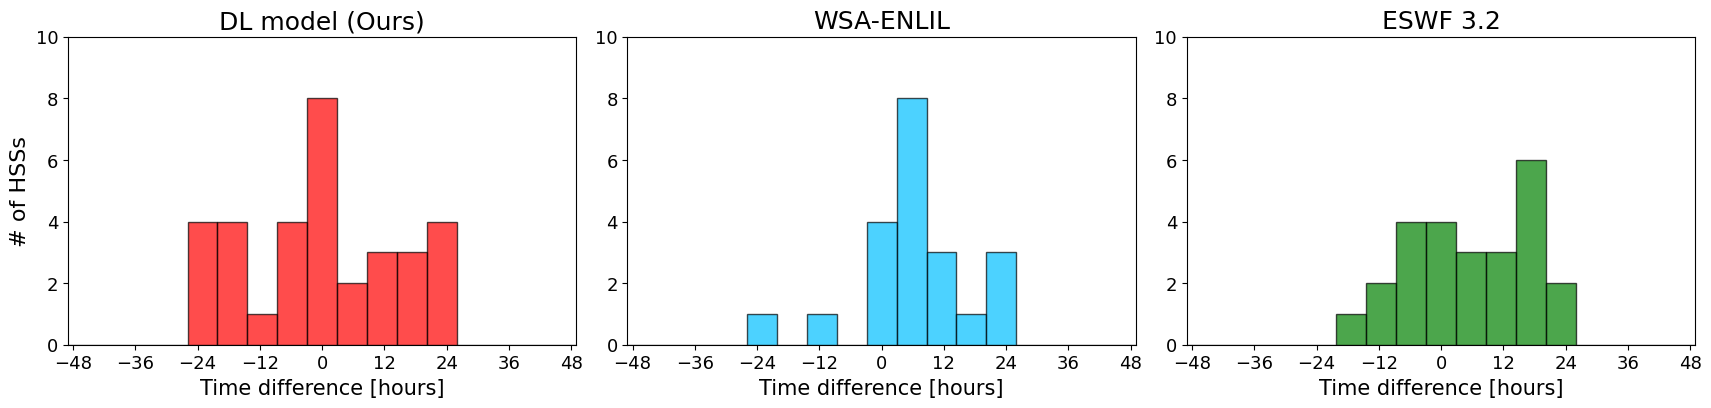

In [8]:
bins = np.linspace(-49, 49, 18)

fig, ax = plt.subplots(1, 3, figsize=(21, 4))
fig.subplots_adjust(wspace=0.1)

data_hours = [td.total_seconds() / 3600 for td in model_hists]
ax[0].hist(data_hours, bins=bins, color='r', edgecolor='black', alpha=0.7)
ax[0].set_xlim([-49, 49])
ax[0].set_ylim([0, 10])
ax[0].set_xticks([-48, -36, -24, -12, 0, 12, 24, 36, 48])
ax[0].tick_params(axis='x', labelsize=13)
ax[0].tick_params(axis='y', labelsize=13)
ax[0].set_xlabel("Time difference [hours]", fontsize = 15)
ax[0].set_ylabel("# of HSSs", fontsize = 16)
ax[0].set_title("DL model (Ours)", fontsize = 18)

data_hours = [td.total_seconds() / 3600 for td in wsa_hists]
ax[1].hist(data_hours, bins=bins, color='deepskyblue', edgecolor='black', alpha=0.7)
ax[1].set_xlim([-49, 49])
ax[1].set_ylim([0, 10])
ax[1].set_xticks([-48, -36, -24, -12, 0, 12, 24, 36, 48])
ax[1].tick_params(axis='x', labelsize=13)
ax[1].tick_params(axis='y', labelsize=13)
ax[1].set_xlabel("Time difference [hours]", fontsize = 15)
#ax[1].set_ylabel("# of HSSs")
ax[1].set_title("WSA-ENLIL", fontsize = 18)

data_hours = [td.total_seconds() / 3600 for td in eswf_hists]
ax[2].hist(data_hours, bins=bins, color='g', edgecolor='black', alpha=0.7)
ax[2].set_xlim([-49, 49])
ax[2].set_ylim([0, 10])
ax[2].set_xticks([-48, -36, -24, -12, 0, 12, 24, 36, 48])
ax[2].tick_params(axis='x', labelsize=13)
ax[2].tick_params(axis='y', labelsize=13)
ax[2].set_xlabel("Time difference [hours]", fontsize = 15)
#ax[2].set_ylabel("# of HSSs")
ax[2].set_title("ESWF 3.2", fontsize = 18)

title_str = "Histogram of time differences (±2-day time window)"
title_str = "Histogram of time differences (adjust)"
save_path = "E:\\research\\SW_Speed_Models_Comparison\\plot_images\\\\{}.png".format(title_str)
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Save figure

plt.show()